# Exercises Bayesian decoding

Martijn Vermeulen, s1129901

In [1]:
import pickle
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from scipy.stats import pearsonr
import sys
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})

In [2]:
import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline 
plt.rcParams['figure.figsize'] = [10, 5]
from ipywidgets import interact
import ipywidgets as widgets


track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population 
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

In [3]:
bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

In [4]:
# GENERATE TRAJECTORY

n_runs = 10
use_stops = False
av_running_speed = 10 # the average running speed (in cm/s)
fps = 10 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])


for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    if use_stops:
        x = np.concatenate((x, stop1, run1, stop2, run2))
    else:
         x = np.concatenate((x, run1, run2))
t = np.arange(len(x))/fps

In [5]:
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 0.1 # the baseline noise firing rate
spikes = []

for i in range(n_cells):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)

In [6]:
import pickle

file_name = 'linear_track_data.pickle' # change this name when you save new data

out_data = {}
out_data['x'] = x
out_data['t'] = t
out_data['spikes'] = spikes
out_data['track_length'] = track_length
out_data['fps'] = fps

with open('data/'+file_name,'wb') as f:
    pickle.dump(out_data,f)

## Exercise 1
---

You can find below the code that was used to generate the activity of place cells on a linear track.
Use the code and the decoding procedure you lerned about in the lesson to explore how different features of the data impact our ability to decode position.
In particular:

A - Try to use different fractions of our data samples. How does the median error change when the the number of available sample gets larger? You do not need to re-generate any data, just randomly sub-sample the data to different fractions.

B - How many place cells do we need to reliably decode position? Try to re-do the decoding using only 10 cell, then 20, and so on. How does the median error change? Does it reach an asymptote? (Also in this case, you do not need to re-generate the data, you can just select a random subset of cells each time)

C - Generate new data using the code below, changing the firing rate noise (changing the value of the variable `noise firing_rate`). How does this noise impact the decoding? 

## Exercise 2
---
In the loop implementation of the decoder, we used `poisson.logpmf(k,mu)` to calculate the log probability of observing $k$ spikes given an average firing rate of $\mu$. 
This is mathematically equivalent to `np.log(poisson.pmf(k,mu))`, in which we calculate the probability, and then take the log.


Re-run the decoding substituting this expression:

```
posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
```

To the line we are using to calculate the posterior.
Do you see any difference in the results? What do you think this is due to?




In [7]:
# we compute the poistion at which each spike was emitted
spike_positions = [np.interp(s, t, x) for s in spikes]
space_bins = np.arange(0., track_length, 5.) # binning in bins of 5 cms

# we compute histograms for each cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
spikes_hist = np.asarray(spikes_hist)

# we also need an "occupancy histogram" in order to normalize the firing rates maps 
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy 

In [8]:
# code decoding
from scipy.stats import poisson

true_x = x[:-1] # get rid of last timepoint to have same length as binned spikes
decoding_times = t[:-1]

x_decoded = np.zeros_like(true_x)
x_decoded_change = np.zeros_like(true_x)
x_decoded_no_log = np.zeros_like(true_x)

spikes_count= [np.histogram(s,t)[0] for s in spikes]
spikes_count = np.asarray(spikes_count).T

for t_bin in tqdm(range(len(decoding_times))):
    if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
        posterior = np.empty(firing_rate_maps.shape[-1])
        posterior_change = np.empty(firing_rate_maps.shape[-1])
        posterior_no_log = np.empty(firing_rate_maps.shape[-1])
        for i in range(len(posterior)):
            # Note that we work with log so that we can sum probabilities
            # instead of multiplying them 
            #posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
            posterior[i] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15))
            posterior_change[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
            posterior_no_log[i] = sum(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15))
            #print('no log',poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15))
            #print('new formula',np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
        x_decoded[t_bin] = space_bins[np.argmax(posterior)]
        x_decoded_change[t_bin] = space_bins[np.argmax(posterior_change)]
        x_decoded_no_log[t_bin] = space_bins[np.argmax(posterior_no_log)]
    else:
        x_decoded[t_bin] = np.nan   
        x_decoded_change[t_bin] = np.nan   
        x_decoded_no_log[t_bin] = np.nan   

100%|█████████████████████████████████████████████████████████████████████████████| 5121/5121 [00:35<00:00, 145.36it/s]


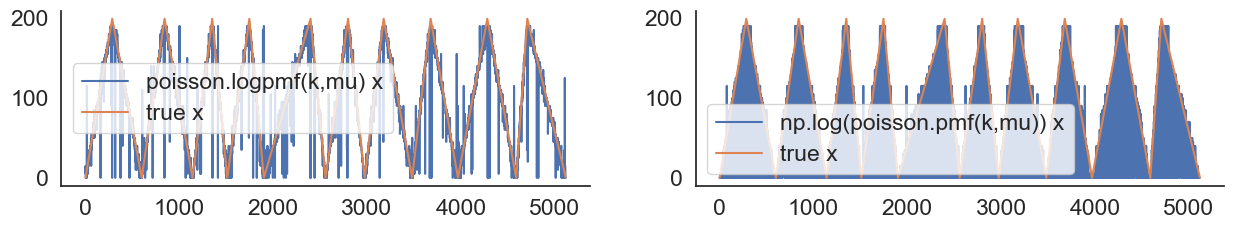

In [9]:
plt.figure(figsize=(15,5))
plt.subplot(2,2,1)
plt.plot(x_decoded,label= 'poisson.logpmf(k,mu) x')
plt.plot(true_x,label = 'true x')
plt.legend()
plt.subplot(2,2,2)
plt.plot(x_decoded_change,label= 'np.log(poisson.pmf(k,mu)) x')
plt.plot(true_x,label = 'true x')
plt.legend()

C:\Users\marti\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Median error: 3.774647887323937 cm
Median error: 10.706174339767976 cm


C:\Users\marti\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


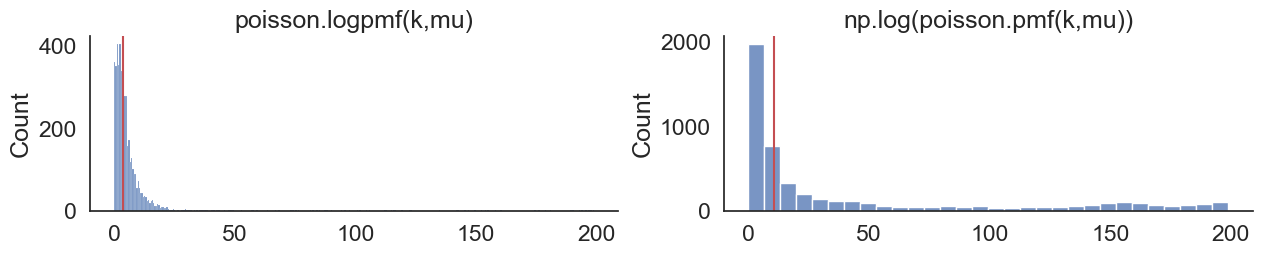

In [10]:
# error distribution
plt.figure(figsize=(15,5))
plt.subplot(2,2,1)
mse = np.sqrt((true_x-x_decoded)**2)
sns.histplot(mse)
plt.axvline(x = np.nanmedian(mse),c='r')
plt.title('poisson.logpmf(k,mu)')
print(f'Median error: {np.nanmedian(mse)} cm')
plt.subplot(2,2,2)
mse = np.sqrt((true_x-x_decoded_change)**2)
sns.histplot(mse)
plt.axvline(x = np.nanmedian(mse),c='r')
plt.title('np.log(poisson.pmf(k,mu))')
print(f'Median error: {np.nanmedian(mse)} cm')

In [11]:
with np.printoptions(threshold=np.inf):
    print(x_decoded_no_log)

[  0.   0.   0.   0.   0.  nan   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   5.   0.   0.   0.   5.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   5.   0.   0.   0.   0.   0.   0.
   0.   0.   5.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.  40.   0.   0.   0.   0.   0.   0.   0.   0.  45.  45.
  45.   0.  50.  50.   0.  50.   0.   0.   0.   0.   0.   0.   0.   0.
   0.  50.   0.   0.  55.  50.   0.   0.   0.  60.  60.   0.   0.  70.
   0.  70.   0.   0.  70.  70.  85.   0.  70.   0.   0.  85.  75.  85.
   0.   0.  85.   0.  85.  90.   0.   0.  85.   0.   0.  85.  90.  85.
  90.  85.   0.   0.   0.  85.  90.  95.  90.   0.   0. 100.   0.  95.
   0.   0. 100.   0. 100.   0.   0.   0. 105. 115. 105. 105. 105.   0.
 100.   0.   0.   0. 115. 115. 115.   0. 115. 115.   0. 115. 115.  nan
 115. 115. 115. 115.   0. 115.   0.   0. 115. 115. 125.   0.   0. 115.
 115. 115.   0. 115. 115. 115. 115. 115. 115.   0.   0. 115. 115. 115.
   0. 

We can see that for the poisson.logpmf(k,mu) we get a nice estimation of the true x. For the np.log(poisson.pmf(k,mu)) values that should belong in the peak but which go to zero. The data gets divided by a factor of 10 it seems like. We can also see in the histogram plots that there is some more error. For the original function the Median error =  3.7103825136611874 cm and for the new function we get Median error = 6.900237529691211 cm. Thus the new function has a higher error.

## Exercise 3
---
A - Estimate the quality of the sequence detection methods we saw in the lesson. How many false poistive does it find? How many false negatives?

B - Investigate the effect of `noise_x_react` and `noise_t_react` on the false positive rate and the false negative rate of our detection procedure.

C - What kind of sequence can our methods detect? What kind of activity, despide being sequential, could escape our detection method? Would you have an idea for a different method for sequence detection?


### Code for data generation